In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

%matplotlib inline

# (A) Nearest Stations

In [3]:
cd geocoding/

/home/ema/Dropbox/ada/solarity/geocoding


In [4]:
import geocoding_functions as geo_fns
import location_functions as loc_fns
import station_info

## User input

In [5]:
address = "DubendorfStrasse 119, 8051 Zurich"

## Parameters

In [6]:
k = 3 ##Number of nearest neighbouring stations

### Get coordinates of the address

In [7]:
coordinates = geo_fns.getCoordinates(address)
if(coordinates is None):
    print("*** Invalid Address ***")
    print("Sample address: Route Cantonale 33, 1025 St. Sulpice")
    exit(0)

In [8]:
coordinates

(47.4025356, 8.5791568)

### Read pickled station info

In [9]:
station_df = pickle.load(open("station_df.p","rb"))

In [10]:
station_df.head()

,name,lat,lng
0,VSVER,46.233333,7.550000
1,VSCOL,46.183333,7.383333
2,AIG,46.333333,6.916667
3,DEM,47.350000,7.350000
4,SRS,46.983333,9.666667


### Get k nearest stations and their weights

In [12]:
neighbourNames = loc_fns.get_k_nearest_neighbours(coordinates, k, station_df)
neighbourWeights = loc_fns.get_weights_for_k_nearest(coordinates, k, station_df)

In [13]:
neighbourNames

193    SMA
129    REH
131    KLO
Name: name, dtype: object

In [14]:
neighbourWeights

array([ 0.60843995,  0.24404087,  0.14751917])

In [15]:
cd ..

/home/ema/Dropbox/ada/solarity


# (B) Solar potential

In [16]:
means = pickle.load(open('learning/groupedStations.p', 'rb'))

In [17]:
def get_monthly_power_potential(stations, weights, means):
    potential = 0
    for i in range(len(stations)):
        potential = potential + means.power[stations[i]].get_values() * weights[i]
    
    return potential

In [18]:
monthly_potential = get_monthly_power_potential(neighbourNames.get_values(), neighbourWeights, means)

In [19]:
potential = np.mean(np.array(monthly_potential)) ## in Wp
potential

0.13263507493695473

# (C) Installation Costs

## User input

In [20]:
averageElectricityBill = np.array([80]) ## CHF
roofArea = 30 ## m2

## Parameters

#### Electricity

In [21]:
elecTarrif = 0.20 ##CHF/Kwh

#### Solar

In [22]:
capacityPerPanel = 255 ## Wp
costPerPanel = 500 ## CHF
panelArea = 1.62 ## m2

## Average Consumption

In [23]:
hours = 24
days = 30
milli = 1000

In [24]:
avgEnergy = averageElectricityBill / elecTarrif
avgEnergy

array([ 400.])

In [25]:
avgPower = avgEnergy / (hours*days) ## Kw
avgPower

array([ 0.55555556])

## Solar Cost and Capacity

In [26]:
installation = np.array(range(5,101,5)) / 100

In [27]:
numPanels = np.floor(roofArea/panelArea)

In [28]:
capacity = installation * numPanels * capacityPerPanel / 1000 ## Kwp
cost = installation * numPanels * costPerPanel ## CHF
solarPower = capacity * potential ## in Kw

In [29]:
solarPower

array([ 0.03043975,  0.0608795 ,  0.09131925,  0.121759  ,  0.15219875,
        0.1826385 ,  0.21307825,  0.243518  ,  0.27395775,  0.3043975 ,
        0.33483725,  0.365277  ,  0.39571675,  0.4261565 ,  0.45659625,
        0.487036  ,  0.51747574,  0.54791549,  0.57835524,  0.60879499])

### Finding suitable installations

In [32]:
indx = solarPower <= avgPower
installationFinal = installation[indx]
installCapacity = capacity[indx]
installCost = cost[indx]
installPower = solarPower[indx]

In [33]:
solar_df = pd.DataFrame()
solar_df['capacity'] = installCapacity
solar_df['cost'] = installCost
solar_df['power'] = installPower
solar_df['installation'] = installationFinal
solar_df = solar_df.set_index('installation')
solar_df

,capacity,cost,power
installation,,,
0.05,0.2295,450.0,0.030440
0.10,0.4590,900.0,0.060879
0.15,0.6885,1350.0,0.091319
0.20,0.9180,1800.0,0.121759
0.25,1.1475,2250.0,0.152199
0.30,1.3770,2700.0,0.182638
0.35,1.6065,3150.0,0.213078
0.40,1.8360,3600.0,0.243518
0.45,2.0655,4050.0,0.273958


# (D) Savings and break-even time

In [34]:
def get_new_bill(bill, power):
    avgEnergyUsed = bill / elecTarrif
    avgEnergyUsed_daytime = avgEnergyUsed / 2
    nightUsage = avgEnergyUsed / 2

    avgEnergyProduced = power * hours * days
    
    newBill = np.empty(len(power))
    newUsageFromUtility = np.empty(len(power))
    for i in range(len(power)):
        dayUsage = max(0, avgEnergyUsed_daytime - avgEnergyProduced[i])
        newUsageFromUtility[i] = dayUsage + nightUsage
        newBill[i] = newUsageFromUtility[i] * elecTarrif

    return newBill, newUsageFromUtility

In [35]:
newBill, newUsage = get_new_bill(averageElectricityBill, installPower)

In [36]:
totalYears = 25
monthsInAYear = 12
def get_cummulative_savings(oldBill, newBill, cost):
    months = range(1, totalYears*monthsInAYear + 1)
    savings = np.empty((len(newBill), len(months)))
    for i in range(len(newBill)):
        eachMonth = oldBill - newBill[i]
        savings[i,:] = eachMonth*months - cost[i]
    return savings

In [37]:
savings = get_cummulative_savings(averageElectricityBill, newBill, installCost)

In [38]:
finalSavings = savings[:,-1]

In [39]:
def get_break_even_time(savings):
    nInstalls = savings.shape[0]
    breakEven = np.empty(nInstalls)
    for i in range(nInstalls):
        breakEven[i] = np.argmax(savings[i,:] > 0)

    return breakEven

In [40]:
breakEven = get_break_even_time(savings)/12

### Prettify Result

In [41]:
newBill

array([ 75.61667604,  71.23335209,  66.85002813,  62.46670417,
        58.08338022,  53.70005626,  49.3167323 ,  44.93340835,
        40.55008439,  40.        ,  40.        ,  40.        ,
        40.        ,  40.        ,  40.        ,  40.        ,
        40.        ,  40.        ])

In [42]:
final_df = solar_df
final_df['breakEvenYears'] = breakEven
final_df['savings_after_25yrs'] = finalSavings
final_df['annual_savings'] = finalSavings/totalYears
final_df

,capacity,cost,power,breakEvenYears,savings_after_25yrs,annual_savings
installation,,,,,,
0.05,0.2295,450.0,0.030440,8.500000,864.997187,34.599887
0.10,0.4590,900.0,0.060879,8.500000,1729.994374,69.199775
0.15,0.6885,1350.0,0.091319,8.500000,2594.991561,103.799662
0.20,0.9180,1800.0,0.121759,8.500000,3459.988748,138.399550
0.25,1.1475,2250.0,0.152199,8.500000,4324.985935,172.999437
0.30,1.3770,2700.0,0.182638,8.500000,5189.983122,207.599325
0.35,1.6065,3150.0,0.213078,8.500000,6054.980309,242.199212
0.40,1.8360,3600.0,0.243518,8.500000,6919.977496,276.799100
0.45,2.0655,4050.0,0.273958,8.500000,7784.974683,311.398987


### Plot savings

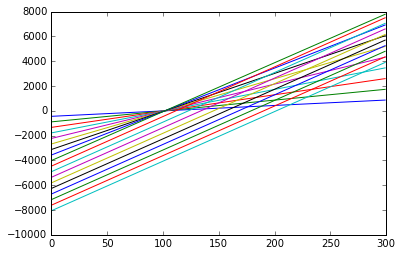

In [43]:
for i in range(savings.shape[0]):
    plt.plot(savings[i,:])